In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

In [52]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

In [87]:
from sklearn.model_selection import train_test_split, GridSearchCV

In [108]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

In [76]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.metrics import accuracy_score, average_precision_score, precision_recall_curve

In [5]:
df = pd.read_csv('./dataset/chapter_1/creditcard_sampledata_3.csv', index_col= 0)
df.shape

(5050, 30)

In [7]:
df.iloc[:4, :13]

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13
258647,1.725265,-1.337256,-1.012687,-0.361656,-1.431611,-1.098681,-0.842274,-0.026594,-0.032409,0.215113,1.618952,-0.654046,-1.442665
69263,0.683254,-1.681875,0.533349,-0.326064,-1.455603,0.101832,-0.520590,0.114036,-0.601760,0.444011,1.521570,0.499202,-0.127849
96552,1.067973,-0.656667,1.029738,0.253899,-1.172715,0.073232,-0.745771,0.249803,1.383057,-0.483771,-0.782780,0.005242,-1.273288
281898,0.119513,0.729275,-1.678879,-1.551408,3.128914,3.210632,0.356276,0.920374,-0.160589,-0.801748,0.137341,-0.156740,-0.429388


In [10]:
df.isnull().sum().sum() # no missing values

0

In [14]:
# All the features are numeric.
df.dtypes.value_counts()

float64    29
int64       1
dtype: int64

In [15]:
df['Class'].value_counts(dropna= False)

0    5000
1      50
Name: Class, dtype: int64

Machine Learning algorithms usually work best when the different classes contained in the dataset are more or less equally present. If there are few cases of fraud, then there's little data to learn how to identify them. This is known as __class imbalance__, and it's one of the main challenges of fraud detection.

In [16]:
def prep_data(df):
    X = df.iloc[:, 1:29]
    X = np.array(X).astype(np.float)
    y = df.iloc[:, 29]
    y=np.array(y).astype(np.float)
    return X,y

In [19]:
# Create X and y from the prep_data function 
X, y = prep_data(df)

In [18]:
# Define a function to create a scatter plot of our data and labels
def plot_data(X, y):
    plt.scatter(X[y == 0, 0], X[y == 0, 1], label="Class #0", alpha=0.5, linewidth=0.15)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], label="Class #1", alpha=0.5, linewidth=0.15, c='r')
    plt.legend()
    return plt.show()

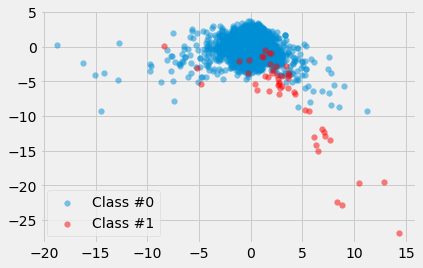

In [20]:
# Plot our data by running our plot data function on X and y
plot_data(X, y)

## Applying SMOTE

you're going to re-balance our data using the Synthetic Minority Over-sampling Technique (SMOTE). Unlike ROS, SMOTE does not create exact copies of observations, but creates new, synthetic, samples that are quite similar to the existing observations in the minority class.

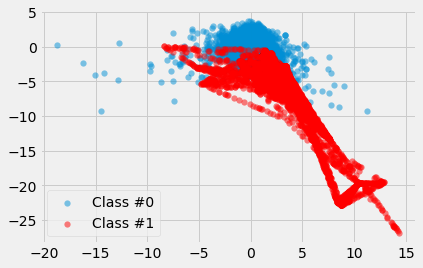

In [29]:
# Run the prep_data function
X, y = prep_data(df)

# Define the resampling method
method = SMOTE(sampling_strategy= 'minority')

# Create the resampled feature set
X_resampled, y_resampled = method.fit_resample(X, y)

# Plot the resampled data
plot_data(X_resampled, y_resampled)

As you can see, our minority class is now much more prominently visible in our data.

In [33]:
pd.Series(y_resampled).value_counts()

0.0    5000
1.0    5000
dtype: int64

In [44]:
def compare_plot(X,y,X_resampled,y_resampled, method):
    # Start a plot figure
    f, (ax1, ax2) = plt.subplots(1, 2)
    # sub-plot number 1, this is our normal data
    c0 = ax1.scatter(X[y == 0, 0], X[y == 0, 1], label="Class #0",alpha=0.5)
    c1 = ax1.scatter(X[y == 1, 0], X[y == 1, 1], label="Class #1",alpha=0.5, c='r')
    ax1.set_title('Original set')
    # sub-plot number 2, this is our oversampled data
    ax2.scatter(X_resampled[y_resampled == 0, 0], X_resampled[y_resampled == 0, 1], label="Class #0", alpha=.5)
    ax2.scatter(X_resampled[y_resampled == 1, 0], X_resampled[y_resampled == 1, 1], label="Class #1", alpha=.5,c='r')
    ax2.set_title(method)
    # some settings and ready to go
    plt.figlegend((c0, c1), ('Class #0', 'Class #1'), loc='lower center', ncol=2, labelspacing=0.)
    #plt.tight_layout(pad=3)
    return plt.show()

0.0    5000
1.0      50
dtype: int64
0.0    5000
1.0    5000
dtype: int64


<Figure size 864x504 with 0 Axes>

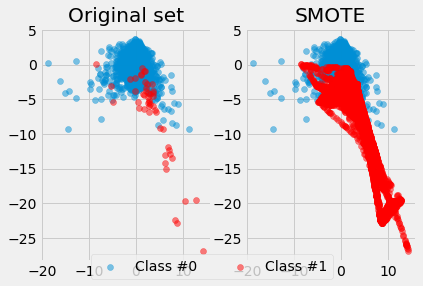

In [43]:
# Print the value_counts on the original labels y
print(pd.value_counts(pd.Series(y)))

# Print the value_counts
print(pd.value_counts(pd.Series(y_resampled)))

# Run compare_plot
compare_plot(X,y,X_resampled,y_resampled, method='SMOTE')

In [46]:
# Get the mean for each group
df[['V1', 'V3', 'Class']].groupby(['Class']).mean()

,V1,V3
Class,,
0,0.035030,0.037444
1,-4.985211,-7.293909


In [47]:
# Implement a rule for stating which cases are flagged as fraud
df['flag_as_fraud'] = np.where(np.logical_and(df['V1'] < -3, df['V3'] < -5), 1, 0)

# Create a crosstab of flagged fraud cases versus the actual fraud cases
pd.crosstab(df['Class'], df['flag_as_fraud'], rownames=['Actual Fraud'], colnames=['Flagged Fraud'])

Flagged Fraud,0,1
Actual Fraud,,
0,4984,16
1,28,22


Not bad, with this rule, we detect 22 out of 50 fraud cases, but can't detect the other 28, and get 16 false positives.

In [50]:
# Create the training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= .3, random_state=0)

# Fit a logistic regression model to our data
model = LogisticRegression()
model.fit(X_train, y_train)

# Obtain model predictions
p_test = model.predict(X_test)

# Print the classifcation report and confusion matrix
print('Classification report:\n', classification_report(y_test, p_test))
conf_mat = confusion_matrix(y_true= y_test, y_pred= p_test)
print('\n\nConfusion matrix:\n', conf_mat)

C:\Users\Heschmat\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1505
         1.0       0.90      0.90      0.90        10

    accuracy                           1.00      1515
   macro avg       0.95      0.95      0.95      1515
weighted avg       1.00      1.00      1.00      1515



Confusion matrix:
 [[1504    1]
 [   1    9]]


Do you think these results are better than the rules based model? We are getting far fewer false positives, so that's an improvement. Also, we're catching a higher percentage of fraud cases, so that is also better than before. Do you understand why we have fewer observations to look at in the confusion matrix? Remember we are using only our test data to calculate the model results on. We're comparing the crosstab on the full dataset from the last exercise, with a confusion matrix of only 30% of the total dataset, so that's where that difference comes from.

In [55]:
"""
borderline1 will select a point from the five nearest points not belonging to the given point's class,
while borderline2 will select a point from the five nearest points of any class.
"""

# Define which resampling method and which ML model to use in the pipeline
resampling = SMOTE(sampling_strategy= 'all')
model = LogisticRegression()

# Define the pipeline, tell it to combine SMOTE with the Logistic Regression model
pipeline = Pipeline([('SMOTE', resampling), ('Logistic Regression', model)])

In [56]:
# Split your data X and y, into a training and a test set and fit the pipeline onto the training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= .3, random_state=0)

# Fit your pipeline onto your training set and obtain predictions by fitting the model onto the test data 
pipeline.fit(X_train, y_train) 
p_pred = pipeline.predict(X_test)

# Obtain the results from the classification report and confusion matrix 
print('Classifcation report:\n', classification_report(y_test, p_pred))
conf_mat = confusion_matrix(y_true= y_test, y_pred= p_pred)
print('\n\nConfusion matrix:\n', conf_mat)

Classifcation report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1505
         1.0       0.60      0.90      0.72        10

    accuracy                           1.00      1515
   macro avg       0.80      0.95      0.86      1515
weighted avg       1.00      1.00      1.00      1515



Confusion matrix:
 [[1499    6]
 [   1    9]]


C:\Users\Heschmat\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


As you can see, the SMOTE slightly improves our results. We now manage to find all cases of fraud, but we have a slightly higher number of false positives, albeit only 7 cases. Remember, not in all cases does resampling necessarily lead to better results. When the fraud cases are very spread and scattered over the data, using SMOTE can introduce a bit of bias. Nearest neighbors aren't necessarily also fraud cases, so the synthetic samples might 'confuse' the model slightly.


Next, we'll learn how to also adjust our machine learning models to better detect the minority fraud cases.

In [59]:
df = pd.read_csv('./dataset/chapter_2/creditcard_sampledata_2.csv', index_col= 0)
df.shape

(7300, 30)

In [60]:
X = df.drop(['Class'], axis= 1)
y = df['Class'].values

In [61]:
X.shape

(7300, 29)

In [62]:
y

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

In [64]:
(y == 0).mean().round(4) * 100 # baseline accuracy

95.89

## Random Forest Classifier

In [66]:
# Split your data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= .3, random_state=0)

# Define the model as the random forest
model = RandomForestClassifier(random_state=5)

In [69]:
# Fit the model to our training set
model.fit(X_train, y_train)

# Obtain predictions from the test data 
predicted = model.predict(X_test)

# Print the accuracy performance metric
print(accuracy_score(y_test, predicted))

0.991324200913242


In [72]:
# Obtain the predictions from our random forest model 
predicted = model.predict(X_test)

# Predict probabilities
probs = model.predict_proba(X_test)

# Print the ROC curve, classification report and confusion matrix
print(roc_auc_score(y_test, probs[:,1]))
print(classification_report(y_test, predicted))
print(confusion_matrix(y_test, predicted))

0.9697317927427505
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2099
           1       0.99      0.80      0.88        91

    accuracy                           0.99      2190
   macro avg       0.99      0.90      0.94      2190
weighted avg       0.99      0.99      0.99      2190

[[2098    1]
 [  18   73]]


Only 1 false positive. However, the model misses 18 cases of actual fraud (18 false negative). Model has high precision, not so good recall.

In [110]:
def plot_pr_curve(recall, precision, average_precision):
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
    plt.show()

In [75]:
# Calculate average precision and the PR curve
average_precision = average_precision_score(y_test, predicted)
average_precision

0.7995764694394831

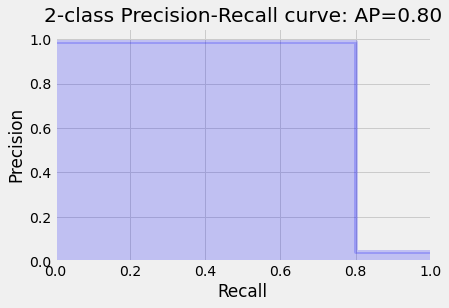

In [77]:
# Obtain precision and recall 
precision, recall, _ = precision_recall_curve(y_test, predicted)

# Plot the recall precision tradeoff
plot_pr_curve(recall, precision, average_precision)

In [78]:
precision

array([0.04155251, 0.98648649, 1.        ])

The ROC curve plots the true positives vs. false positives , for a classifier, as its discrimination threshold is varied. Since, a random method describes a horizontal curve through the unit interval, it has an AUC of 0.5. Minimally, classifiers should perform better than this, and the extent to which they score higher than one another (meaning the area under the ROC curve is larger), they have better expected performance.

The AUROC is the probability that a random positive sample will have a higher score than a random negative sample.

## Adjusting your Random Forest to fraud detection

In [79]:
# Define the model with balanced subsample
model = RandomForestClassifier(class_weight='balanced_subsample', random_state=5)

# Fit your training model to your training set
model.fit(X_train, y_train)

# Obtain the predicted values and probabilities from the model 
predicted = model.predict(X_test)
probs = model.predict_proba(X_test)

# Print the roc_auc_score, the classification report and confusion matrix
print(roc_auc_score(y_test, probs[:, 1]))
print(classification_report(y_test, predicted))
print(confusion_matrix(y_test, predicted))

0.9560963095979771
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2099
           1       0.99      0.81      0.89        91

    accuracy                           0.99      2190
   macro avg       0.99      0.91      0.94      2190
weighted avg       0.99      0.99      0.99      2190

[[2098    1]
 [  17   74]]


By setting the weight ratio to 1:12, we get to a 1/3 fraud to 2/3 non-fraud ratio, which is good enough for training the model on.

In [84]:
# Change the model options
model = RandomForestClassifier(n_estimators=20,
                               bootstrap=True,
                               class_weight={0:1, 1:12},
                               criterion='entropy',
                               max_depth=10,
                               min_samples_leaf=10,
                               n_jobs=-1,
                               random_state= 0)

In [111]:
def get_model_results(X_train, y_train, X_test, y_test, model):
    model.fit(X_train, y_train)
    predicted = model.predict(X_test)
    #probs = model.predict_proba(X_test)
    print (classification_report(y_test, predicted))
    print (confusion_matrix(y_test, predicted))

In [86]:
# Run the function get_model_results
get_model_results(X_train, y_train, X_test, y_test, model)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2099
           1       0.94      0.84      0.88        91

    accuracy                           0.99      2190
   macro avg       0.97      0.92      0.94      2190
weighted avg       0.99      0.99      0.99      2190

[[2094    5]
 [  15   76]]


As you see, we are catching more cases of fraud, whilst keeping the number of false positives low.

### GridSearchCV to find optimal parameters

In [96]:
# Define the parameter sets to test
param_grid = {
    'n_estimators': [50, 100, 200],
      'max_features': ['auto', .5], 
      'max_depth': [7, 9, 11],
    'ccp_alpha': [0, .0001, .001]
}

# Define the model to use
model = RandomForestClassifier(random_state=5)

# Combine the parameter sets with the defined model
CV_model = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='recall', n_jobs=-1)

# Fit the model to our training data and obtain best parameters
CV_model.fit(X_train, y_train)
CV_model.best_params_

{'ccp_alpha': 0, 'max_depth': 9, 'max_features': 'auto', 'n_estimators': 200}

In [105]:
# play with n_estimators: 40, 50, 100, 200 ()
model = RandomForestClassifier(class_weight={0:1,1:12},
            max_features= 'auto', max_depth=9,  min_samples_leaf=10, n_estimators=40, n_jobs=-1, random_state=5)

# Get results from your model
get_model_results(X_train, y_train, X_test, y_test, model)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2099
           1       0.97      0.84      0.90        91

    accuracy                           0.99      2190
   macro avg       0.98      0.92      0.95      2190
weighted avg       0.99      0.99      0.99      2190

[[2097    2]
 [  15   76]]


To decide which final model is best, you need to take into account how bad it is not to catch fraudsters, versus how many false positives the fraud analytics team can deal with. Ultimately, this final decision should be made by you and the fraud team together.

### VotingClassifier

In [106]:
# Define the Logistic Regression model with weights
model = LogisticRegression(class_weight={0:1,1:15}, random_state=5)

# Get the model results
get_model_results(X_train, y_train, X_test, y_test, model)

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2099
           1       0.65      0.88      0.75        91

    accuracy                           0.98      2190
   macro avg       0.82      0.93      0.87      2190
weighted avg       0.98      0.98      0.98      2190

[[2056   43]
 [  11   80]]


C:\Users\Heschmat\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


As you can see the Logistic Regression has quite different performance from the Random Forest. More false positives, but also a better Recall. It will therefore will a useful addition to the Random Forest in an ensemble model.

In [112]:
# Define the three classifiers to use in the ensemble
lr = LogisticRegression(class_weight={0:1, 1:15}, random_state=5)

rf = RandomForestClassifier(class_weight={0:1, 1:12}, criterion='gini', max_depth=8, max_features='log2',
            min_samples_leaf=10, n_estimators=30, n_jobs=-1, random_state=5)

dt = DecisionTreeClassifier(random_state=5, class_weight="balanced")

# Combine the classifiers in the ensemble model
# REMEMBER: predict_proba is not available when voting='hard'
ensemble_model = VotingClassifier(estimators=[('lr', lr), ('rf', rf), ('dt', dt)], voting= 'hard')

# Get the results 
get_model_results(X_train, y_train, X_test, y_test, ensemble_model)

C:\Users\Heschmat\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Heschmat\miniconda3\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2099
           1       0.90      0.86      0.88        91

    accuracy                           0.99      2190
   macro avg       0.95      0.93      0.94      2190
weighted avg       0.99      0.99      0.99      2190

[[2090    9]
 [  13   78]]


You see that by combining the classifiers, you can take the best of multiple models. You've increased the cases of fraud you are catching from 76 to 78, and you only have 5 extra false positives in return. If you do care about catching as many fraud cases as you can, whilst keeping the false positives low, this is a pretty good trade-off. The Logistic Regression as a standalone was quite bad in terms of false positives, and the Random Forest was worse in terms of false negatives. By combining these together you indeed managed to improve performance.

By increasing or decreasing weights you can play with how much emphasis you give to a particular model relative to the rest. This comes in handy when a certain model has overall better performance than the rest, but you still want to combine aspects of the others to further improve your results.

In [114]:
# Define the ensemble model
ensemble_model = VotingClassifier(estimators=[('lr', lr), ('rf', rf), ('gnb', dt)],
                                  voting='soft',
                                  weights=[1, 4, 1],
                                  flatten_transform=True)

# Get results 
get_model_results(X_train, y_train, X_test, y_test, ensemble_model)

C:\Users\Heschmat\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Heschmat\miniconda3\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2099
           1       0.94      0.86      0.90        91

    accuracy                           0.99      2190
   macro avg       0.97      0.93      0.95      2190
weighted avg       0.99      0.99      0.99      2190

[[2094    5]
 [  13   78]]
